<a href="https://colab.research.google.com/github/Nielspace/Learning-DataScience/blob/master/Module%2002%20-%20Random%20Forest/03%20Interpretation%20of%20RandomForrest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Importing the Libraries

In [0]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import pydotplus
from IPython import display
from io import StringIO

# Data Collection 

In [3]:
%cd drive/My\ Drive/Data\ Science

/content/drive/My Drive/Data Science


In [0]:
PATH = "data-bluebook-for-bulldozers/"

In [5]:
!ls {PATH}

'Data Dictionary.xlsx'		    Train.7z	        Valid.7z
 Machine_Appendix.csv		    TrainAndValid.7z    Valid.csv
 median_benchmark.csv		    TrainAndValid.csv   ValidSolution.csv
 random_forest_benchmark_test.csv   TrainAndValid.zip   Valid.zip
 Test.csv			    Train.csv


In [0]:
data_raw = pd.read_csv(f'{PATH}Train.csv',low_memory=False, 
                     parse_dates=["saledate"] )

## Learning the data

In [0]:
data_prac = data_raw.copy()

In [8]:
data_prac.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,521D,521,D,NaN,NaN,NaN,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,950FII,950,F,II,NaN,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,NaN,EROPS w AC,None or Unspecified,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,23.5,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,226,226,NaN,NaN,NaN,NaN,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,OROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,PC120-6E,PC120,NaN,-6E,NaN,Small,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,NaN,EROPS w AC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2 Valve,NaN,NaN,NaN,NaN,NaN,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,S175,S175,NaN,NaN,NaN,NaN,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,NaN,EROPS,None or Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Auxiliary,NaN,NaN,NaN,NaN,NaN,None or Unspecified,None or Unspecified,None or Unspecified,Standard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
data_prac.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null datetime64[ns]
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                

In [0]:
def assigning_categorical(data, column):
    categories = []
    for i in data[column].unique():
        categories.append(i)
    try:    
        categories.remove(np.nan)
    except Exception as e:
        pass
    data[column+'_new'] = pd.Categorical(data[column], categories=categories, ordered=True).codes
    data.drop(f'{column}', axis=1, inplace = True)
    data.replace(-1, np.nan, inplace=True)

In [0]:
for i in data_prac.columns:
    if data_prac[i].dtype == 'O':
        try:
            assigning_categorical(data_prac, i)
        except Exception as e:
            pass

In [0]:
data_prac['saleyear'] = data_prac['saledate'].dt.year
data_prac.drop('saledate', axis=1,inplace=True)

In [0]:
data_prac.SalePrice = np.log(data_prac.SalePrice)

In [0]:
for i in data_prac.columns:
    data_prac[i] = data_prac[i].fillna(data_prac[i].median())

In [0]:
X = data_prac.drop('SalePrice', axis=1)
y = data_prac.SalePrice

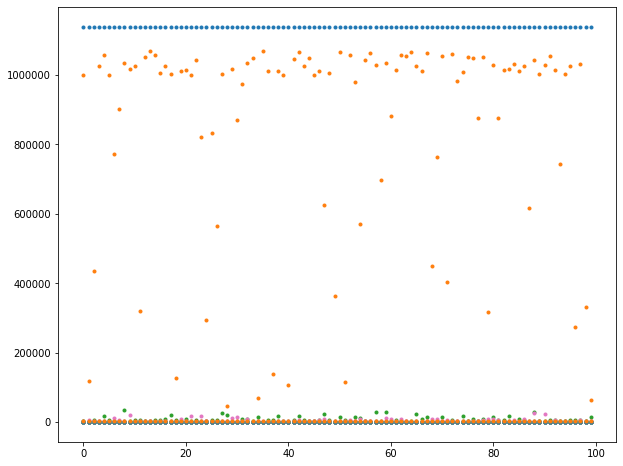

In [16]:
plt.figure(figsize=(10,8))
plt.plot(X[:100], '.')

# Training

In [17]:
forr = RandomForestRegressor(n_jobs=-1)
%time forr.fit(X,y)
forr.score(X,y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


CPU times: user 1min 7s, sys: 166 ms, total: 1min 7s
Wall time: 34.5 s


0.9817170067265928

# Creating Validation Set

In [18]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(X)-n_valid
raw_train, raw_valid = split_vals(data_prac, n_trn)
X_train, X_valid = split_vals(X, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 52), (389125,), (12000, 52))

In [0]:
import math
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [20]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.5513536884318515, 0.5727537785897261, 0.36467580537988425, 0.4141534186104833]


In [0]:
import graphviz
import IPython
import re

def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))

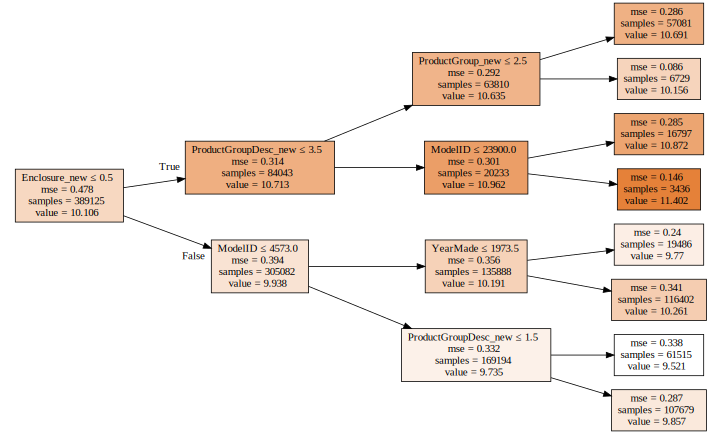

In [22]:
draw_tree(m.estimators_[0], X, precision=3)

In [23]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.09371043812988696, 0.254574821521593, 0.9816468437152943, 0.8842612280616025]


In [24]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[:1]

(array([9.21034037, 9.13237883, 9.21034037, 9.21034037, 9.10497986,
        9.10497986, 9.10497986, 9.25913054, 9.15904708, 9.10497986]),
 9.16014969854427,
 389125    9.10498
 Name: SalePrice, dtype: float64)

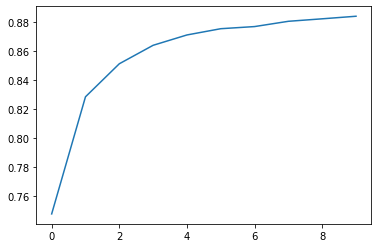

In [25]:
from sklearn.metrics import r2_score
plt.plot([r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

# Playing with hyperparameter

In [0]:
data_sample = data_prac.sample(10000)

X = data_sample.drop('SalePrice', axis=1)
y = data_sample.SalePrice

X_train, X_valid = split_vals(X, 9000)
y_train, y_valid = split_vals(y, 9000)

In [27]:
m = RandomForestRegressor(n_estimators=25, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m) #I like this model

[0.1849845024609039, 0.3050959665758093, 0.9287692190108153, 0.8051402689449048, 0.781031172273058]


In [28]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=4, max_features='sqrt', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.26091880159439684, 0.33629964805014995, 0.8582876288768801, 0.7632434559267272, 0.7519851049861835]


In [29]:
m = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m) #not good

[0.2641041032419175, 0.3500307935480087, 0.8548064540758459, 0.7435151770941094, 0.7211226804394777]


In [30]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.18336718532799579, 0.3016641299463899, 0.930009313751951, 0.8094993283080545, 0.7299265915994826]


In [31]:
m = RandomForestRegressor(n_estimators=35, min_samples_leaf=4, max_features='log2', n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.2871783550767249, 0.35285206739282815, 0.8283276225590768, 0.7393639416801476, 0.7340515875071258]


# Model Interpretation

- So far we have done the following operations:
  1. Load the data
  2. Cleaned the data. That is, 
    - Convert the objects into intergers, since we can only model using numbers
    - Trained the model using random forest regressor. 
    - Tuned the hyperparameter
    - Predicted the output with various insights we achieved from training the model.

- In the next part we will see how we can interpret the model. Using various statistical approaches--like confidence intervals, feature importance etc-- we will dig more deeper into the knowlegde of the data. This will help us to recommend and improve our skills of interpretation. 

# Confidence Interval

Normally, we do not just want a prediction — we also want to know how confident we are of that prediction.

What if we took the standard deviation of the predictions of the trees? If the standard deviation is high, that means each tree is giving us a very different estimate of this row’s prediction. If this was a really common kind of row, the trees would have learned to make good predictions for it because it has seen lots of opportunities to split based on those kind of rows. So the standard deviation of the predictions across the trees gives us at least relative understanding of how confident we are of this prediction.

### Standard deviation should be close to zero

In [32]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 49.3 ms, sys: 1.97 ms, total: 51.3 ms
Wall time: 53.2 ms


(10.359380007099007, 0.4273157038317481)

<center>The standard deviation is a description of the data's spread, how widely it is distributed about the mean.  A smaller standard deviation indicates that more of the data is clustered about the mean.  A larger one indicates the data are more spread out.</center>

In [0]:
raw_train, raw_valid = split_vals(data_sample, 9000)

In [34]:
X_train.shape, X_valid.shape, 

((9000, 52), (1000, 52))

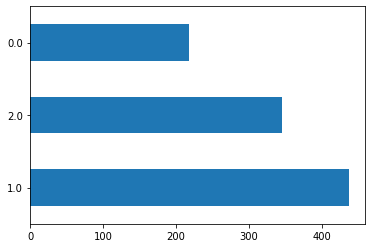

In [35]:
x = raw_valid.copy()
x['pred'] = np.std(preds, axis=0)
x['pred_std'] = np.std(preds, axis=0)
x.Enclosure_new.value_counts().plot.barh();

In [36]:
flds = ['Enclosure_new', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure_new', as_index=False).mean()
enc_summ

,Enclosure_new,SalePrice,pred,pred_std
0,0.0,10.659468,0.338359,0.338359
1,1.0,9.798027,0.260398,0.260398
2,2.0,10.068613,0.317486,0.317486


<center><b>For model interpretation, there is no need to use the full dataset because we do not need a massively accurate random forest — we just need one which indicates the nature of relationships involved</center>

- A good way to explain any model is to <b>visualise the model. </b>
- A good visualisation always depends upon a good explaination 
- Choose a graph which you can interpret and explain better. 


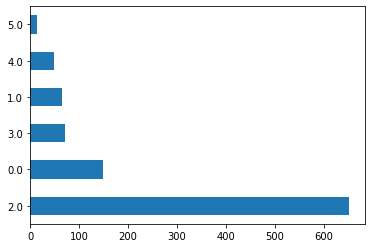

In [37]:
raw_valid.ProductSize_new.value_counts().plot.barh()

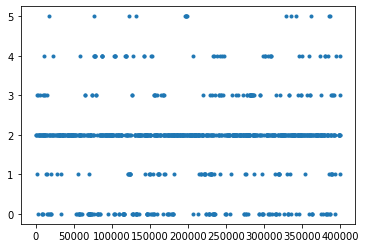

In [38]:
plt.plot(raw_valid.ProductSize_new, '.')

In [0]:
import seaborn as sb

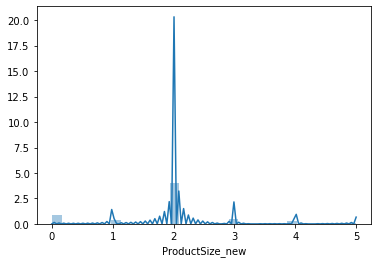

In [40]:
sb.distplot(raw_valid.ProductSize_new)

(array([148.,   0.,  66.,   0., 651.,   0.,  72.,   0.,  48.,  15.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

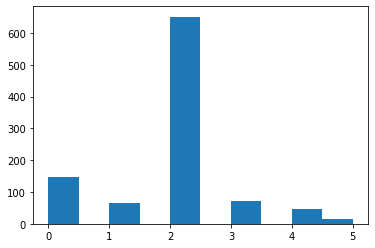

In [41]:
plt.hist(raw_valid.ProductSize_new)

# Feature Importance



In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

In [43]:
feature_importances.head()

,importance
Enclosure_new,0.134484
ModelID,0.093029
YearMade,0.079108
ProductGroup_new,0.055764
ProductSize_new,0.053229


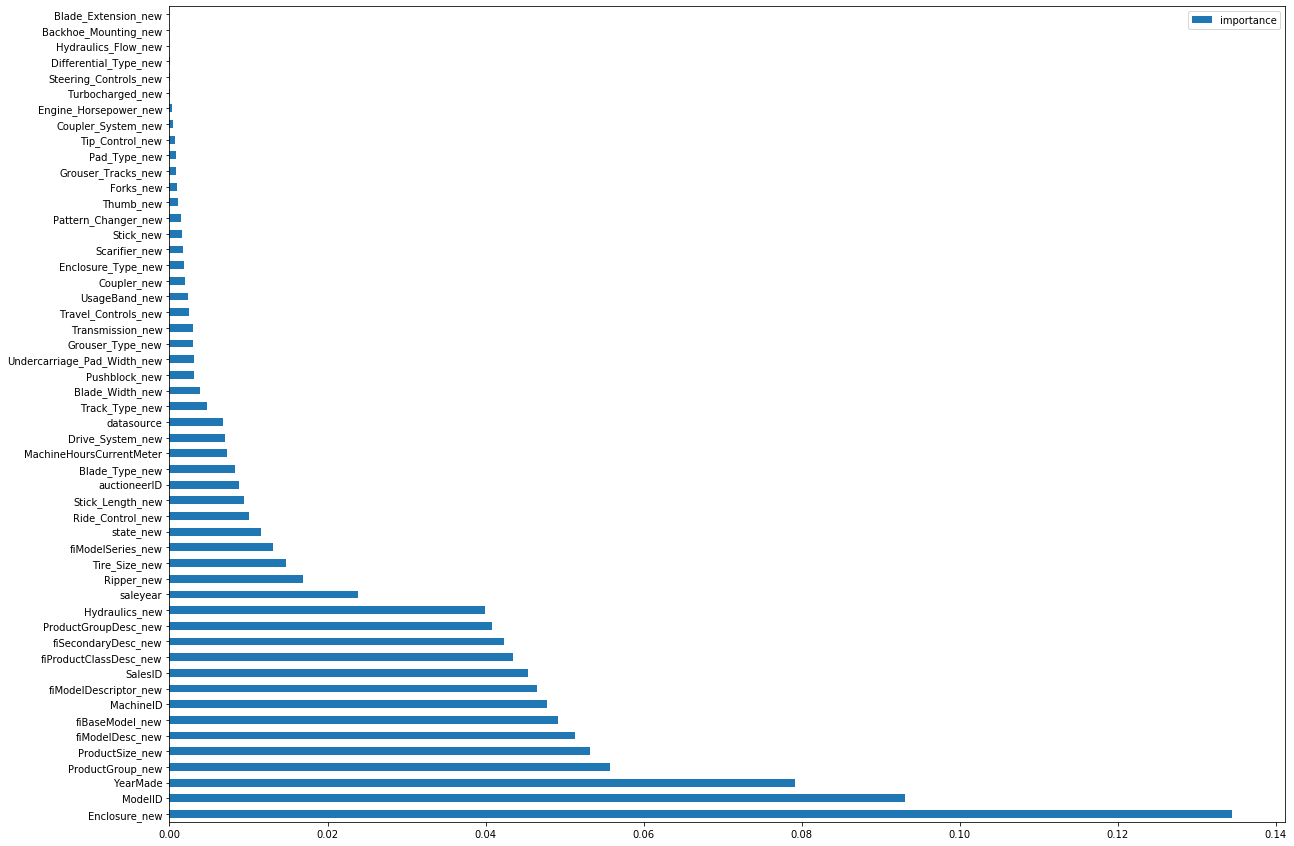

In [44]:
feature_importances.plot.barh(figsize=(20,15))

In [0]:
def to_keep(data, column, sep_value): return data.loc[data[f'{column}']>sep_value], data.loc[data[f'{column}']>sep_value].index

In [0]:
toKeep, importantCol = to_keep(feature_importances, 'importance', 0.05)

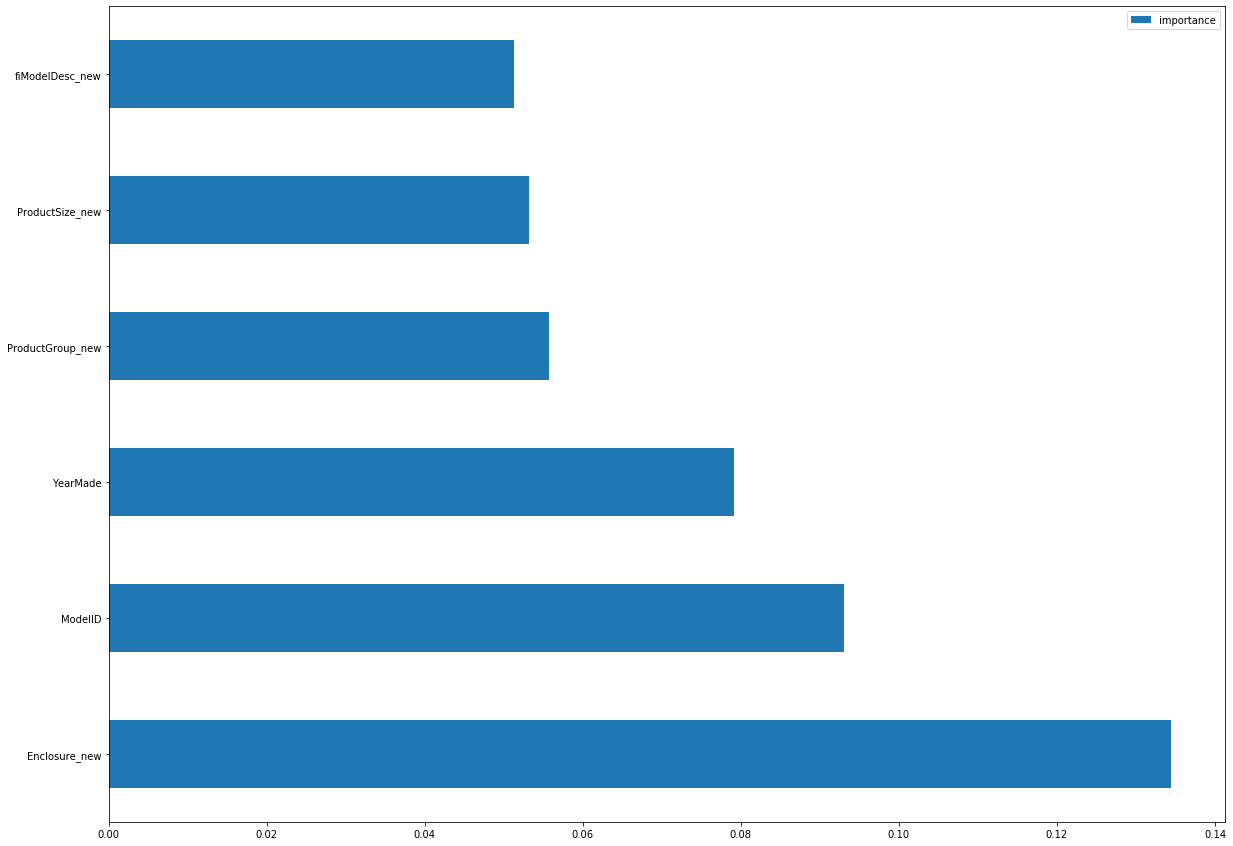

In [47]:
toKeep.plot.barh(figsize=(20,15))

In [48]:
df_keep = X[importantCol].copy(); df_keep.shape

(10000, 6)

In [0]:
X_train, X_valid = split_vals(df_keep, 9000)
y_train, y_valid = split_vals(y, 9000)

In [50]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((9000, 6), (9000,), (1000, 6), (1000,))

In [51]:
m = RandomForestRegressor(n_estimators=25, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.26987262702219567, 0.3427856275867321, 0.8483945940426558, 0.7540230709509111, 0.7323881765786091]


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

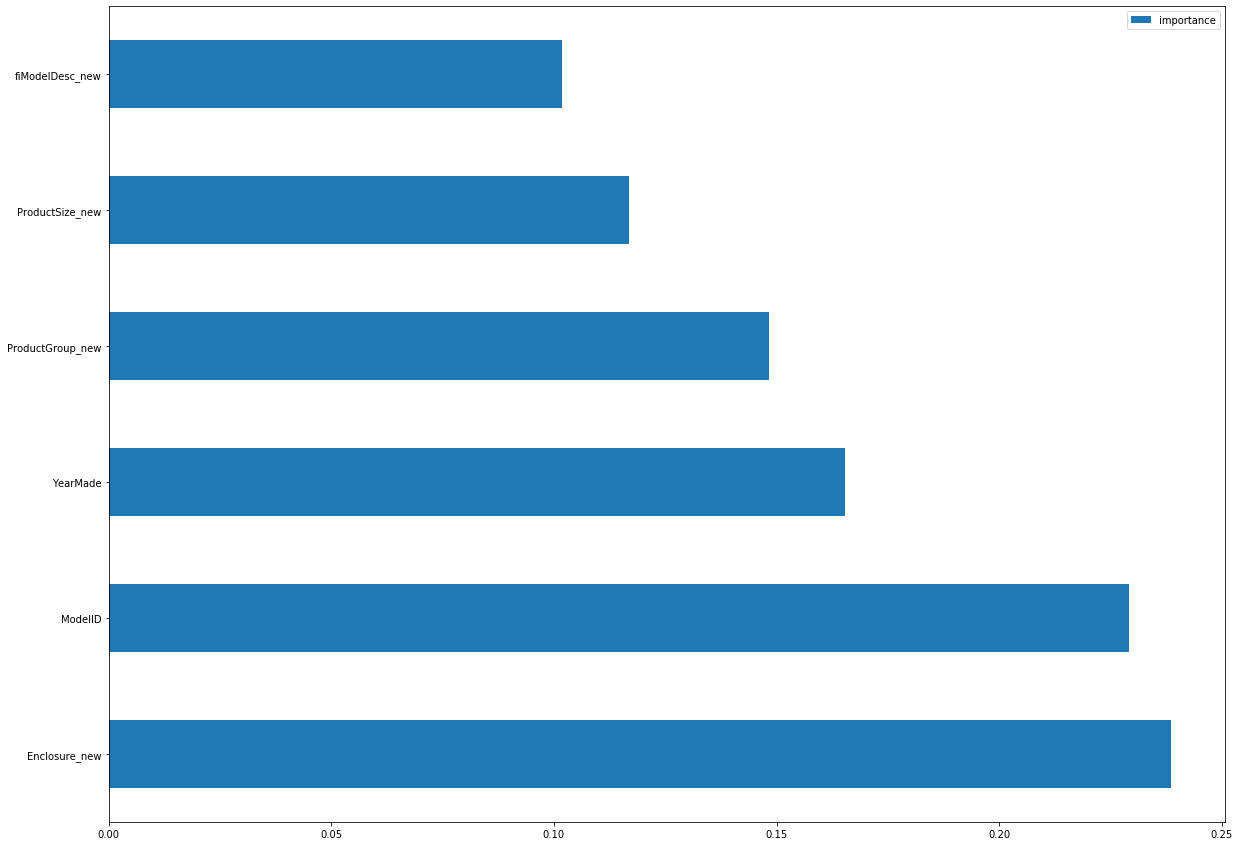

In [53]:
feature_importances.plot.barh(figsize=(20,15))

## Shuffling the important features

1. Check whether shuffling gives you a good result.
2. If it does then it means that coLinearity has been removed. 
3. Else, if your valid RMSE or score gets worse then it must be overfitting. 

# To avoid overfitting make sure that your validation set is random sample

In [54]:
X_train['Enclosure_new'] = np.random.permutation(X_train.Enclosure_new.values)
X_train.shape

(9000, 6)

In [55]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=7, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.305616449613618, 0.34223044487142795, 0.8055757345887857, 0.7548192043879806, 0.7387137323857875]


In [56]:
X_train['ModelID'] = np.random.permutation(X_train.ModelID.values); X_train['ModelID'].head()

375060     3178
213398     3538
49998      3199
292735    23162
30365      6908
Name: ModelID, dtype: int64

In [57]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=7, max_features="log2", n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.32943340703464574, 0.37679763538474426, 0.774091646632595, 0.7027885724315046, 0.6903622044511617]


In [58]:
X_train['YearMade'] = np.random.permutation(X_train.YearMade.values); X_train['YearMade'].head() 

375060    1988
213398    1994
49998     1981
292735    2002
30365     1983
Name: YearMade, dtype: int64

In [59]:
m = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:737: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


[0.3001671072470491, 0.44070800657099496, 0.8124473459571502, 0.5934152852648018, 0.4969238821108697]


Since year made gave me the worst result I will reset the data set back to the orginal and then continue to investigate further to get more insights. 

In [0]:

# Reseting the model

X_train, X_valid = split_vals(df_keep, 9000)
y_train, y_valid = split_vals(y, 9000)

In [61]:
m = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.26714517920152137, 0.34204434763666003, 0.8514434868187044, 0.7550857795169248, 0.74504966054128]


# One Hot-encoding

In [0]:
def OneHotEncoding(data, n_values):
  columns_to_be_encoded = []
  for i in data.columns:
    if len(data[i].unique())<n_values:
      columns_to_be_encoded.append(i)
  for j in columns_to_be_encoded:
    col = pd.get_dummies(data[j], prefix=j)
    data = pd.concat([data, col],axis=1 )
    
  return data

In [0]:
encoded_data = OneHotEncoding(df_keep,5)

In [0]:
X_train, X_valid = split_vals(encoded_data, 9000)
y_train, y_valid = split_vals(y, 9000)

In [65]:
X_train.shape, y_train.shape

((9000, 9), (9000,))

In [66]:
m = RandomForestRegressor(n_estimators=25, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.27460909770329184, 0.34799713351885514, 0.8430263138518366, 0.7464868452991036, 0.7295004470537062]


In [0]:
feature_importances = pd.DataFrame(m.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',  ascending=False)

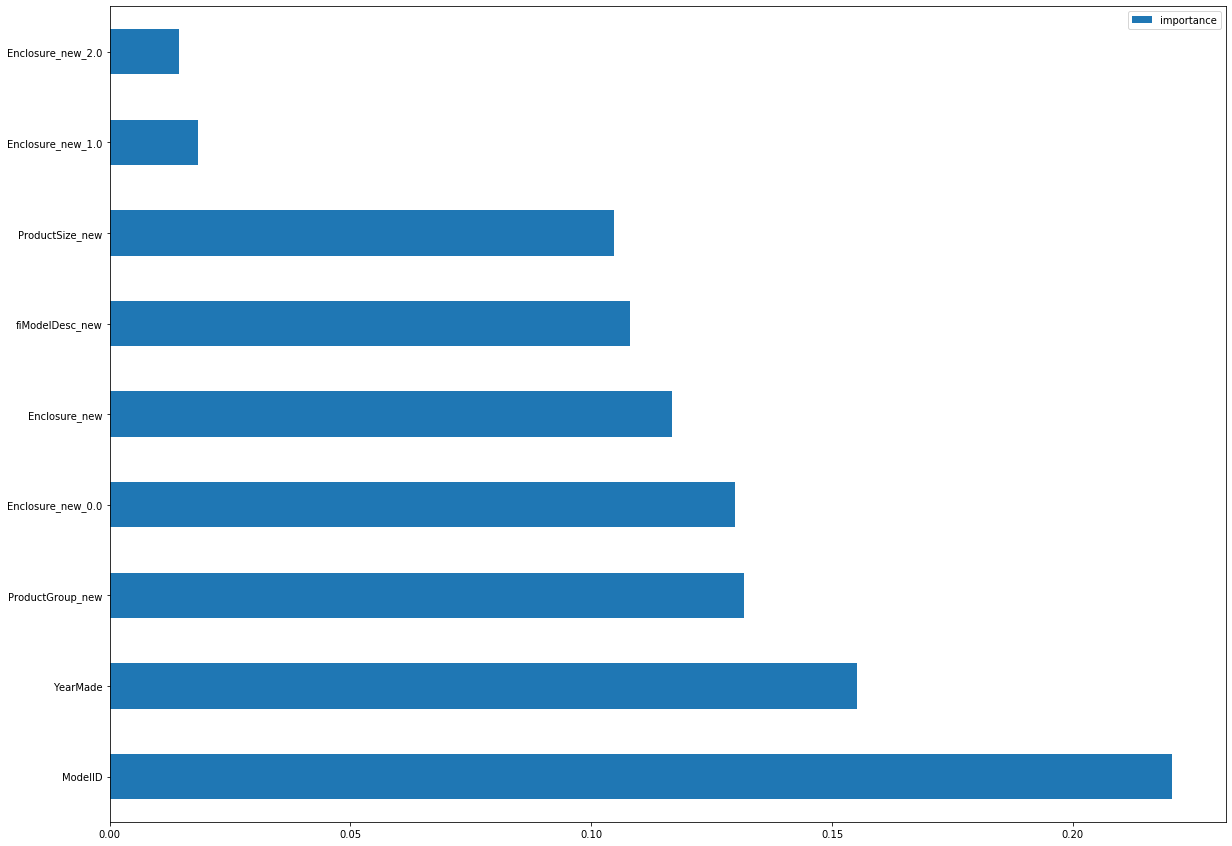

In [68]:
feature_importances.plot.barh(figsize=(20,15))

In [0]:
from scipy.cluster import hierarchy as hc
import scipy

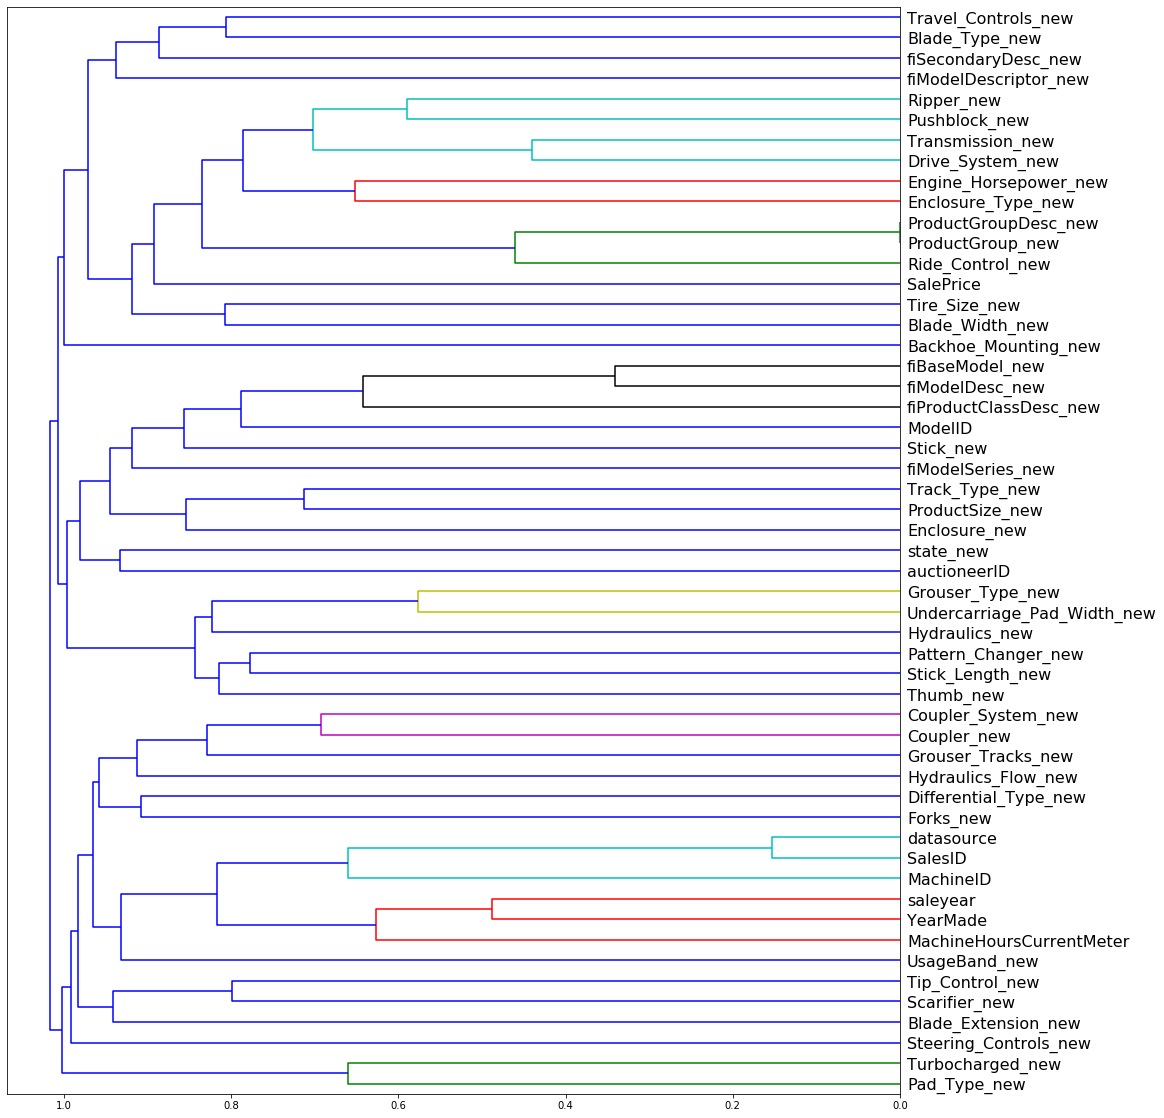

In [70]:
corr = np.round(scipy.stats.spearmanr(data_prac).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,20))
dendrogram = hc.dendrogram(z, labels=data_prac.columns, orientation='left', leaf_font_size=16)
plt.show()

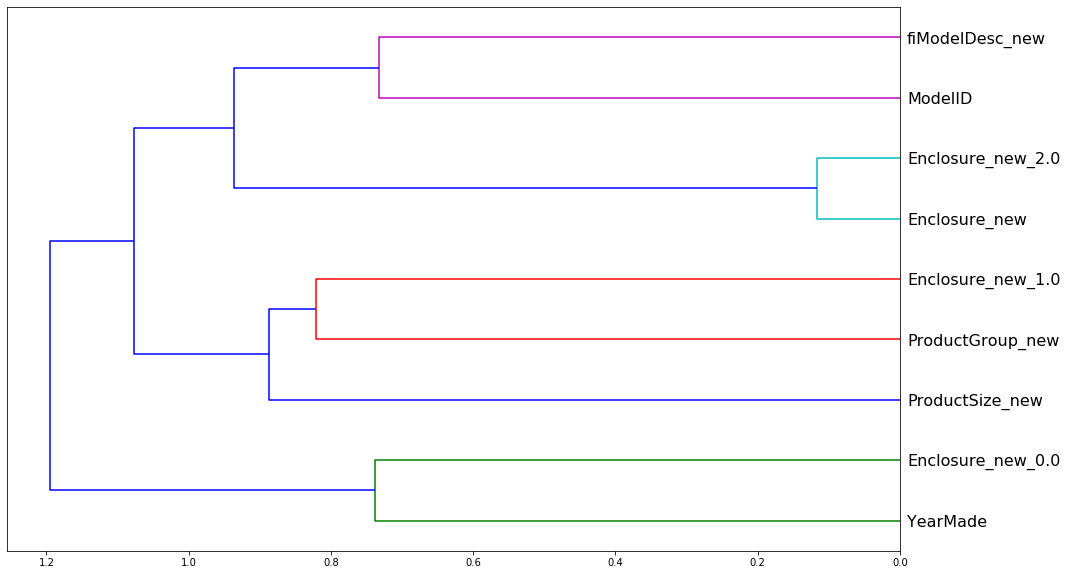

In [71]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

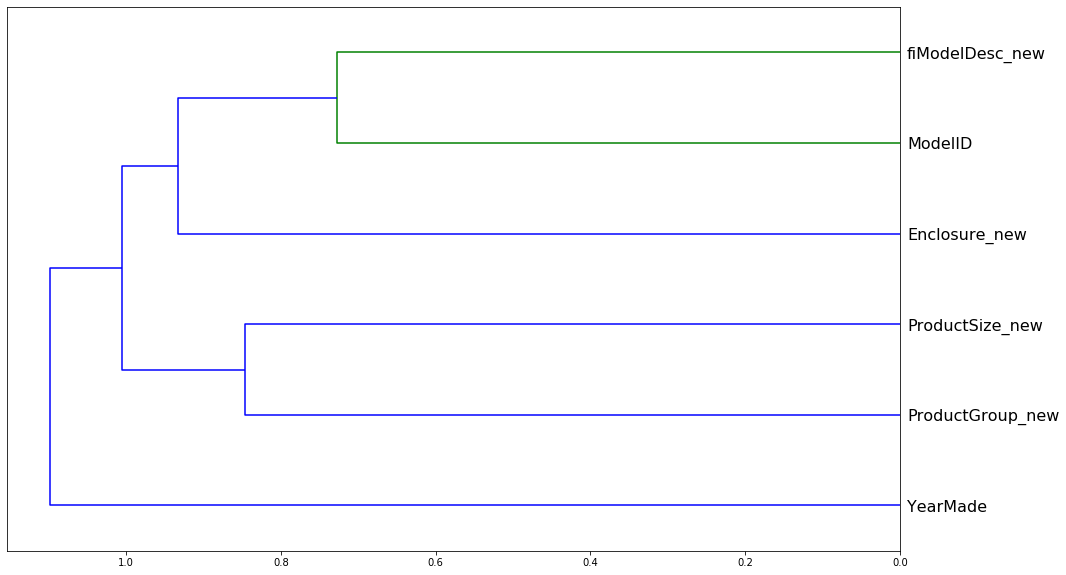

In [72]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [0]:
def get_oob(df):
    # m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    m = RandomForestRegressor(n_estimators=45, min_samples_leaf=5, max_features=0.5, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, 9000)
    m.fit(x, y_train)
    return m.oob_score_

In [74]:
get_oob(df_keep)

0.7379122136322027

In [76]:
for c in ('ModelID', 'fiModelDesc_new'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

ModelID 0.7184335219239795
fiModelDesc_new 0.7306085253496082


In [77]:
to_drop = ['ModelID']
get_oob(df_keep.drop(to_drop, axis=1))

0.7194869829536819

In [0]:
X = data_prac.drop('SalePrice', axis=1)
y = data_prac.SalePrice

# data_prac.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(data_prac, n_trn)
y_train, y_valid = split_vals(data_prac.SalePrice, n_trn)

# Our Final Model

In [79]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.0022467270744554488, 0.004848520225726819, 0.9999894504128595, 0.9999580176836138, 0.9999505038226923]
